## Importing all libraries

In [121]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # for saving and loading sklearn object
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tribikram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tribikram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading data file

In [86]:
BASEDIR = os.path.dirname(os.path.dirname(os.path.abspath('README.md')))
DATAPATH = os.path.join(BASEDIR, 'data')
df = pd.read_csv(os.path.join(DATAPATH,'ISEAR.csv'), names = ['emotion', 'text'])
df.head()

,emotion,text
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


Number of tuples: 7446


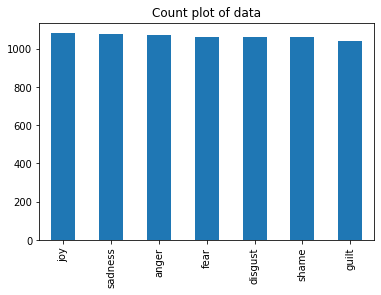

In [87]:
print('Number of tuples: {}'.format(len(df)))
df['emotion'].value_counts().plot(kind = 'bar', title = 'Count plot of data')

This shows that the data are uniformly distributed across different class.

In [88]:
len(stopwords.words('english'))

179

In [89]:
def preprocess(X):
    documents = []
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)

        documents.append(document)
    return documents

df['text'] = preprocess(df['text'])

We will use sklearn countvector to convert string features to numerical features. Let's see how countvector works

In [116]:
count_vec = CountVectorizer(encoding = 'string')
corpus = [
    'This is first document.',
    'This is document in second document.',
    'And this is third document.',
    'Is this the first document?'
]
feature = count_vec.fit_transform(corpus)
print(count_vec.get_feature_names())

['and', 'document', 'first', 'in', 'is', 'second', 'the', 'third', 'this']


In [120]:
print(feature.toarray())

[[0 1 1 0 1 0 0 0 1]
 [0 2 0 1 1 1 0 0 1]
 [1 1 0 0 1 0 0 1 1]
 [0 1 1 0 1 0 1 0 1]]


Now we can use term frequency inverse frequency to supress the common words like is, am, are etc which has no spefical significance. Sklearn provies tfidftransformer for this task.

In [122]:
tfidf= TfidfTransformer()
new_feature = tfidf.fit_transform(feature.toarray()).toarray()
new_feature


array([[0.        , 0.43508727, 0.657341  , 0.        , 0.43508727,
        0.        , 0.        , 0.        , 0.43508727],
       [0.        , 0.54749662, 0.        , 0.52458135, 0.27374831,
        0.52458135, 0.        , 0.        , 0.27374831],
       [0.59581303, 0.31091996, 0.        , 0.        , 0.31091996,
        0.        , 0.        , 0.59581303, 0.31091996],
       [0.        , 0.3341742 , 0.50487895, 0.        , 0.3341742 ,
        0.        , 0.64037493, 0.        , 0.3341742 ]])

Now working with our data

In [124]:
unigram_vectorizer = CountVectorizer(encoding = 'string', ngram_range=(1, 1), stop_words = stopwords.words('english'))
x= unigram_vectorizer.fit_transform(df['text']).toarray()
len(unigram_vectorizer.get_feature_names())

7984

In [125]:
x.shape

(7446, 7984)

In [126]:

tfidfconverter = TfidfTransformer()
tfidfconverter.fit(x)
X = tfidfconverter.transform(x)

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df['emotion'])
y = encoder.transform(df['emotion'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [129]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))


[[102  28  20  16  11  17  23]
 [ 35 118  15  10  13   6  19]
 [  5  15 145  10   5   8   9]
 [ 30  18  24  90  14  25  19]
 [ 12  10  11  10 153  18  13]
 [ 13   7  15  11  13 121  10]
 [ 21  27  19  35  23   7  91]]
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       217
           1       0.53      0.55      0.54       216
           2       0.58      0.74      0.65       197
           3       0.49      0.41      0.45       220
           4       0.66      0.67      0.67       227
           5       0.60      0.64      0.62       190
           6       0.49      0.41      0.45       223

    accuracy                           0.55      1490
   macro avg       0.55      0.55      0.55      1490
weighted avg       0.55      0.55      0.55      1490

0.5503355704697986


In [108]:
os.path.abspath('ISEAR.csv')

'/home/tribikram/Desktop/sentiment/ISEAR.csv'

In [107]:
import os
os.path.dirname(os.path.abspath('ISEAR.csv'))

'/home/tribikram/Desktop/sentiment'

In [109]:
os.path.dirname(os.path.dirname(os.path.abspath('ISEAR.csv')))

'/home/tribikram/Desktop'